# 预训练 BERT
:label:`sec_bert-pretraining`

在:numref:`sec_bert`中实现的BERT模型和从:numref:`sec_bert-dataset`中的WikiText-2数据集生成的预训练示例的基础上，我们将在本节中使用WikiText-2数据集对BERT进行预训练。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

首先，我们将WikiText-2数据集加载为用于掩码语言模型和下一句预测的预训练示例的小批量。批量大小为512，BERT输入序列的最大长度为64。请注意，在原始的BERT模型中，最大长度为512。

In [2]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

BadZipFile: File is not a zip file

## 预训练 BERT

原始的 BERT 有两个不同模型大小的版本 :cite:`Devlin.Chang.Lee.ea.2018`。
基础模型 ($\textrm{BERT}_{\textrm{BASE}}$) 使用 12 层（Transformer 编码器块）
包含 768 个隐藏单元（隐藏层大小）和 12 个自注意力头。
大型模型 ($\textrm{BERT}_{\textrm{LARGE}}$) 使用 24 层
包含 1024 个隐藏单元和 16 个自注意力头。
值得注意的是，前者有 1.1 亿个参数，而后者有 3.4 亿个参数。
为了便于演示，
我们定义 [**一个小的 BERT，使用 2 层、128 个隐藏单元和 2 个自注意力头**]。

In [3]:
net = d2l.BERTModel(len(vocab), num_hiddens=128,
                    ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

在定义训练循环之前，我们定义一个辅助函数 `_get_batch_loss_bert`。给定训练样本的分片，该函数[**计算掩码语言模型和下一句预测任务的损失**]。请注意，BERT 预训练的最终损失仅仅是掩码语言模型损失和下一句预测损失的总和。

In [4]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

调用上述两个辅助函数，
以下的 `train_bert` 函数
定义了在 WikiText-2 (`train_iter`) 数据集上预训练 BERT (`net`) 的过程。
预训练 BERT 可能需要很长时间。
与 `train_ch13` 函数中指定训练的 epoch 数不同（见 :numref:`sec_image_augmentation`），
以下函数的输入 `num_steps`
指定了训练的迭代步数。

In [5]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

我们可以在BERT预训练期间绘制掩码语言模型损失和下一句预测损失。

MLM loss 5.885, NSP loss 0.760
4413.2 sentence pairs/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


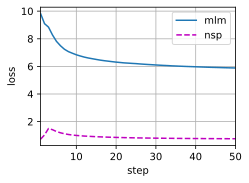

In [6]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

## [**使用BERT表示文本**]

在预训练BERT之后，
我们可以用它来表示单个文本、文本对或其中的任何标记。
以下函数返回`tokens_a`和`tokens_b`中所有标记的BERT（`net`）表示。

In [7]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

[**考虑句子“a crane is flying”。**]
回想一下在:numref:`subsec_bert_input_rep`中讨论的BERT输入表示。
在插入特殊标记“&lt;cls&gt;”（用于分类）和“&lt;sep&gt;”（用于分隔）后，
BERT的输入序列长度为六。
由于零是“&lt;cls&gt;”标记的索引，
`encoded_text[:, 0, :]`是整个输入句子的BERT表示。
为了评估多义词“crane”，
我们还打印出该词的BERT表示的前三个元素。

In [8]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([0.8414, 1.4830, 0.8226], device='cuda:0', grad_fn=<SliceBackward0>))

[**现在考虑一个句子对
"a crane driver came" 和 "he just left".**]
同样地，`encoded_pair[:, 0, :]` 是从预训练的 BERT 中得到的整个句子对的编码结果。
请注意，“crane”这个词在不同上下文中的前三个元素是不同的。
这支持了 BERT 表示是上下文敏感的。

In [9]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([0.0430, 1.6132, 0.0437], device='cuda:0', grad_fn=<SliceBackward0>))

在:numref:`chap_nlp_app`中，我们将微调一个预训练的BERT模型用于下游自然语言处理应用。

## 摘要

* 原始的BERT有两个版本，其中基础模型有1.1亿个参数，而大型模型有3.4亿个参数。
* 在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何标记。
* 在实验中，相同的标记在不同上下文中的BERT表示是不同的。这支持了BERT表示是上下文敏感的观点。

## 练习

1. 在实验中，我们可以看到掩码语言建模损失明显高于下一句预测损失。为什么？
2. 将BERT输入序列的最大长度设置为512（与原始BERT模型相同）。使用原始BERT模型的配置，如$\textrm{BERT}_{\textrm{LARGE}}$。在运行此部分时是否会遇到任何错误？为什么？

[讨论](https://discuss.d2l.ai/t/1497)